<a href="https://colab.research.google.com/github/marekpiotradamczyk/ml_uwr_22/blob/main/kmeans_deep_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep features via k-means

The following notebook is based on the following paper 
https://www-cs.stanford.edu/~acoates/papers/coatesng_nntot2012.pdf

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import scipy.stats as sstats

from sklearn import datasets
import sklearn.linear_model

from matplotlib import animation, pyplot, rc
import matplotlib.pyplot as plt

import httpimport

from PIL import Image


In [2]:
!pip install -q gdown httpimport
![ -e cifar.npz ] || gdown 'https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR' -O cifar.npz

In [3]:
with np.load('cifar.npz') as data:
    cifar_train_data = data['train_data']
    cifar_train_labels = data['train_labels']
    cifar_test_data = data['test_data']
    cifar_test_labels = data['test_labels']



In [4]:
# let's load data 
#(X_trn, y_trn), (X_tst, y_tst) = cifar10.load_data()
X_trn = cifar_train_data
y_trn = cifar_train_labels
X_tst = cifar_test_data
y_tst = cifar_test_labels


In [5]:
X_trn.shape

(50000, 32, 32, 3)

In [6]:
X_tst.shape

(10000, 32, 32, 3)

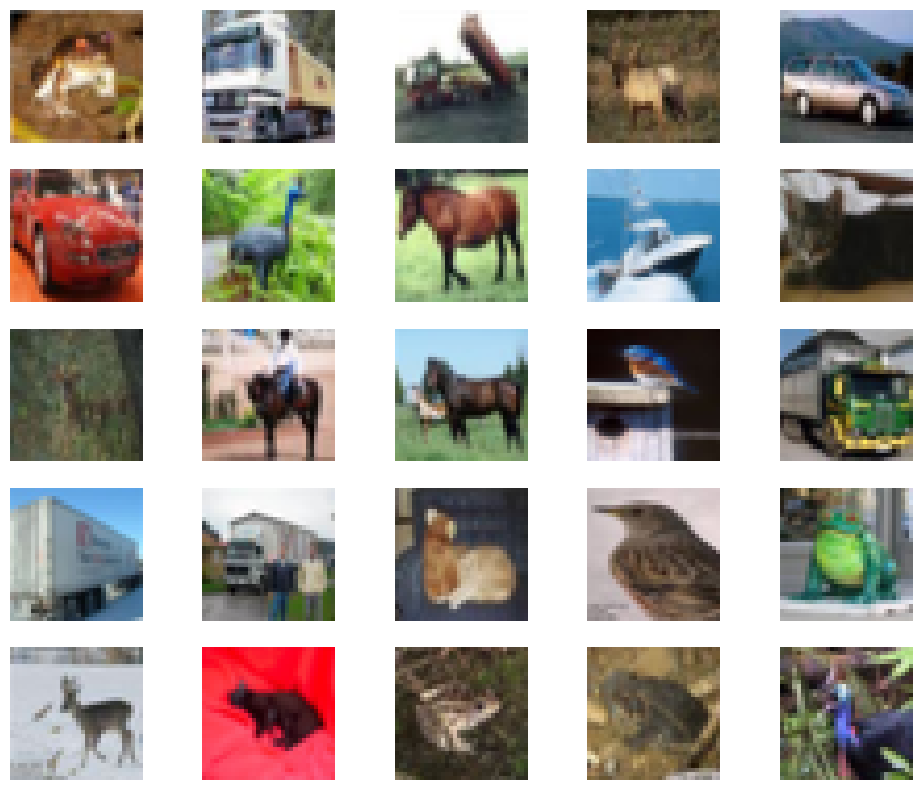

In [7]:
def show_sample(X):
    plt.figure(figsize=(12,10))
    for xx in range(25):
        plt.subplot(5,5,xx+1)
        plt.imshow(X[xx, :].reshape(32,32,3))
        plt.axis('off')
    
show_sample(X_trn)

# Simple Logistic Regression

In [8]:
X_trn_norm = (X_trn.reshape(-1,32*32*3) - X_trn.reshape(-1,32*32*3).mean(axis=0))/X_trn.reshape(-1,32*32*3).std(axis=0)
X_tst_norm = (X_tst.reshape(-1,32*32*3) - X_trn.reshape(-1,32*32*3).mean(axis=0))/X_trn.reshape(-1,32*32*3).std(axis=0)

In [9]:
X_trn_norm.shape

(50000, 3072)

In [10]:
from sklearn.linear_model import LogisticRegression

clf_simple = LogisticRegression(random_state=0, max_iter=100, verbose=True, n_jobs=-1).fit(X_trn_norm, y_trn.flatten())



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        30730     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15129D+05    |proj g|=  3.58073D+03


 This problem is unconstrained.



At iterate   50    f=  8.18947D+04    |proj g|=  1.88037D+02

At iterate  100    f=  7.96532D+04    |proj g|=  2.66715D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
30730    100    105      1     0     0   2.667D+02   7.965D+04
  F =   79653.209515124778     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   34.8s finished


In [11]:
y_trn_pred = clf_simple.predict(X_trn_norm)
print((y_trn.flatten() == y_trn_pred).mean())

0.46202


In [12]:
y_tst_pred = clf_simple.predict(X_tst_norm)
print((y_tst.flatten() == y_tst_pred).mean())

0.3979


# Deep Features

## find important patterns in patches

In [13]:
def contrast(image):
    return (image-image.min())/(image.max() - image.min())

In [14]:
def normalize_patch(patch, eps=10):
    return (patch - patch.mean())/np.sqrt(patch.var() + eps)


In [15]:
def whiten(X):
    X_norm = (X - X.mean(axis=0))/X.std(axis=0)
    cov = np.cov(X_norm, rowvar=False) 
    U,S,V = np.linalg.svd(cov)

    #zca_matrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T))
    X_zca = U.dot(np.diag(1.0/np.sqrt(S + 0.1))).dot(U.T).dot(X_norm.T).T
    return X_zca

In [16]:
def plotImage(X):
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(X.reshape(32,32,3))
    plt.show()
    plt.close()

### Let's get some intuition for what whitening does

In [17]:
X_zca = whiten(X_trn[:1000].reshape(-1,32*32*3))

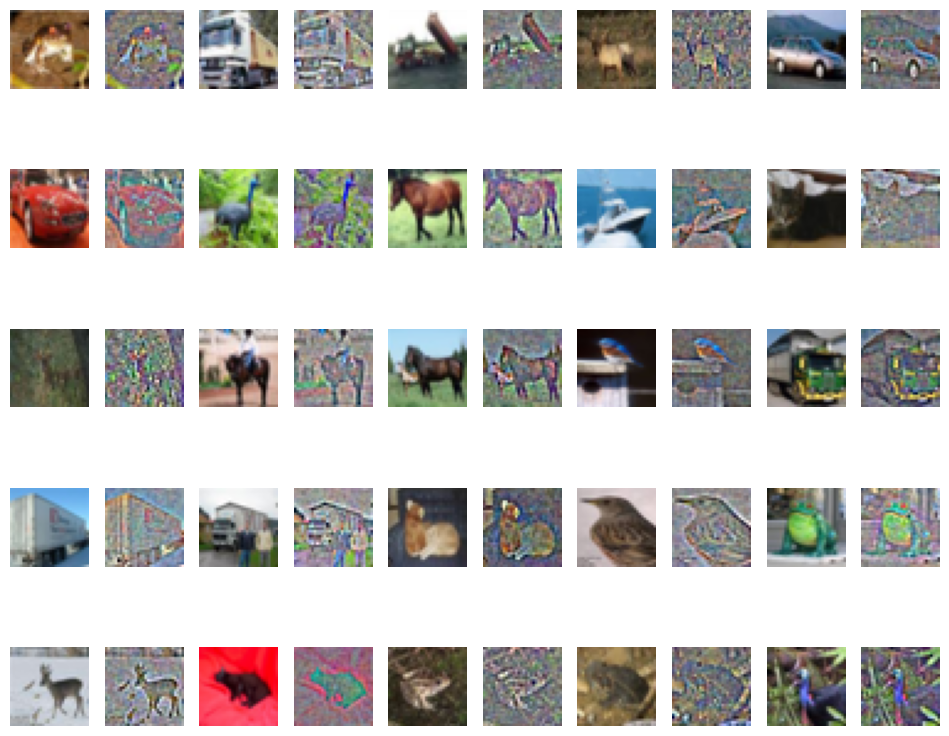

In [18]:
plt.figure(figsize=(12,10))
for xx in range(25):
    plt.subplot(5,10,2*xx+1)
    plt.imshow(X_trn[xx, :].reshape(32,32,3))
    plt.axis('off')
    plt.subplot(5,10,2*xx+2)
    plt.imshow(contrast(X_zca[xx, :]).reshape(32,32,3))
    plt.axis('off')
    

### Back to the feature extraction

In [19]:
PATCH_SIZE = 4
patch_num = 1000000
STRIDE = 4


In [20]:
X_trn.shape

(50000, 32, 32, 3)

In [21]:
patches = []
for i in range(patch_num):
  for r in range(32-PATCH_SIZE+1):
    for c in range(32-PATCH_SIZE+1):
      patch = X_trn[i].reshape(32,32,3)[c:(c+PATCH_SIZE),r:(r+PATCH_SIZE)].flatten()
      patch_norm = normalize_patch(patch, eps=10)
      patches.append(patch_norm)
  if len(patches) >= patch_num:
    break   

In [22]:
P = np.vstack(patches)
P.shape

(1000790, 48)

In [23]:
P_zca = whiten(P)

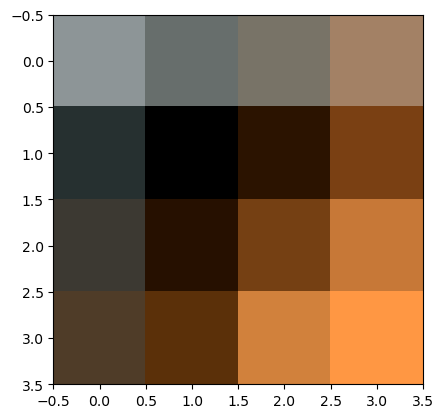

In [24]:
plt.imshow(contrast(P[0].reshape(PATCH_SIZE, PATCH_SIZE, 3)))

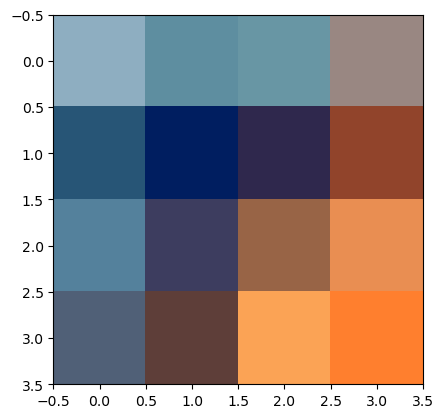

In [25]:
plt.imshow(contrast(P_zca[0].reshape(PATCH_SIZE, PATCH_SIZE, 3)))

In [26]:
kroot = 16
k = kroot*kroot

In [27]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import numpy as np
kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, verbose=True, n_init=1, max_iter=200, batch_size=10000)
kmeans.fit(P_zca)
kmeans.labels_
kmeans.cluster_centers_


Init 1/1 with method k-means++
Inertia for init 1/1: 450959.8593846854
[MiniBatchKMeans] Reassigning 9 cluster centers.
Minibatch step 1/20015: mean batch inertia: 14.98315510146144
[MiniBatchKMeans] Reassigning 5 cluster centers.
Minibatch step 2/20015: mean batch inertia: 13.478464989976846, ewa inertia: 13.478464989976846
[MiniBatchKMeans] Reassigning 1 cluster centers.
Minibatch step 3/20015: mean batch inertia: 13.199475055044674, ewa inertia: 13.472889601410559
Minibatch step 4/20015: mean batch inertia: 13.092389749776968, ewa inertia: 13.465285619127874
Minibatch step 5/20015: mean batch inertia: 13.1286186684535, ewa inertia: 13.458557601975954
Minibatch step 6/20015: mean batch inertia: 12.873415947754966, ewa inertia: 13.44686401851605
Minibatch step 7/20015: mean batch inertia: 12.892793789640809, ewa inertia: 13.435791372401622
Minibatch step 8/20015: mean batch inertia: 12.953167849882572, ewa inertia: 13.426146531020775
Minibatch step 9/20015: mean batch inertia: 12.9786

array([[ 0.14222536,  0.36211942, -0.27262611, ...,  0.43261444,
         0.71349216, -0.20196903],
       [ 0.272288  ,  0.28599981,  0.34276708, ...,  0.21279491,
         0.24887226,  0.38089255],
       [ 0.05226896, -0.20149974,  0.12568901, ..., -0.03864519,
         0.41419189, -0.50734431],
       ...,
       [ 0.65532694,  0.72854747,  0.60294978, ...,  0.03079274,
        -0.03002095, -0.0248214 ],
       [-0.00651118,  0.15903488,  0.37014659, ..., -0.07843439,
         0.12570746,  0.4495836 ],
       [-0.39078334, -0.50727402, -0.41144376, ...,  0.42162121,
         0.47255575,  0.52072806]])

In [28]:
filters_final = kmeans.cluster_centers_
filters_final.shape

(256, 48)

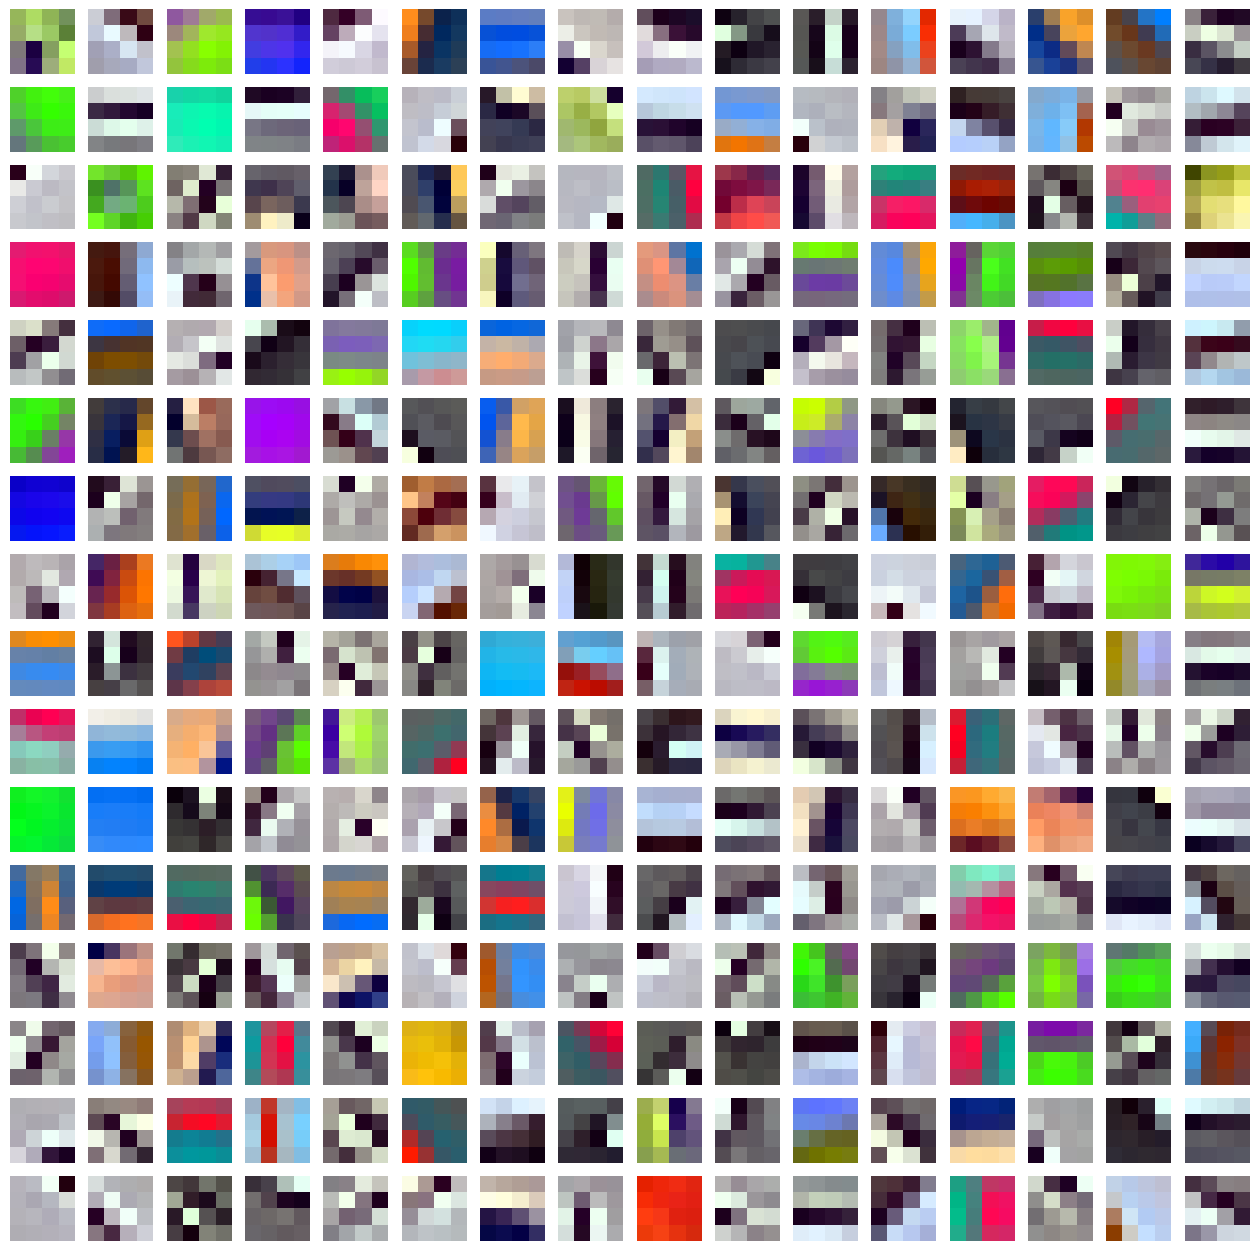

In [29]:
plt.figure(figsize=(kroot,kroot))
for xx in range(k):
    plt.subplot(kroot,kroot,xx+1)
    plt.imshow((contrast(filters_final[xx])).reshape(PATCH_SIZE, PATCH_SIZE, 3))
    plt.axis('off')
    

# transform dataset according to the patterns found in patches




In [30]:
def dist(x,y):
  return np.sqrt((x - y).dot(x-y))
  #return (x-y).dot(x-y)
    
def create_patch_features(X):    
    X_mapped_list_per_image = []
    for i in range(X.shape[0]):
      if i % 1000 == 0:
        print(i,"/", X.shape[0])
        
      mapped_features = []
      for r in range(0, 32-PATCH_SIZE+1, STRIDE):
        for c in range(0, 32-PATCH_SIZE+1, STRIDE):
          patch = X[i].reshape(32,32,3)[c:(c+PATCH_SIZE),r:(r+PATCH_SIZE)].flatten()
          patch_norm = normalize_patch(patch, eps=0.01)
          mapped_features.append([dist(patch_norm, f) for f in filters_final])
      X_mapped_list_per_image.append(np.vstack(mapped_features))
    X_mapped = np.asarray(X_mapped_list_per_image).reshape(-1, ((32-PATCH_SIZE)//STRIDE+1)**2*filters_final.shape[0])
    return X_mapped

In [31]:
from sklearn.feature_extraction import image
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances

def create_patch_features__vectorized(X):    
    X_mapped_list_per_image = []
    for i in range(X.shape[0]):
        if i % 5000 == 0:
            print(i,"/", X.shape[0])
        patches = image.extract_patches_2d(X[i], (PATCH_SIZE, PATCH_SIZE))
        strided_patches = patches.reshape( 32-PATCH_SIZE+1 , 32-PATCH_SIZE+1, PATCH_SIZE, PATCH_SIZE, 3)[::STRIDE,::STRIDE,:,:,:]
        strided_patches = strided_patches.reshape(((32-PATCH_SIZE)//STRIDE+1)**2, PATCH_SIZE * PATCH_SIZE * 3)
        mapped_features = euclidean_distances(np.asarray([normalize_patch(patch, eps=0.01) for patch in strided_patches]), filters_final)
        X_mapped_list_per_image.append(mapped_features.reshape(((32-PATCH_SIZE)//STRIDE+1)**2 * filters_final.shape[0]))
    X_mapped = np.asarray(X_mapped_list_per_image)
    return X_mapped

In [32]:
X_mapped_trn = create_patch_features__vectorized(X_trn)

0 / 50000
5000 / 50000
10000 / 50000
15000 / 50000
20000 / 50000
25000 / 50000
30000 / 50000
35000 / 50000
40000 / 50000
45000 / 50000


In [33]:
X_mapped_trn.shape

(50000, 16384)

In [34]:
X_mapped_tst = create_patch_features__vectorized(X_tst)

0 / 10000
5000 / 10000


In [35]:
X_mapped_tst.shape

(10000, 16384)

# Logistic Regression on mapped features

In [36]:
X_mapped_trn_norm = (X_mapped_trn - X_mapped_trn.mean(axis=0))/X_mapped_trn.std(axis=0)

In [37]:
X_mapped_tst_norm = (X_mapped_tst - X_mapped_trn.mean(axis=0))/X_mapped_trn.std(axis=0)

In [38]:
X_mapped_trn_norm.std(axis=0).sum()

16384.0

In [39]:
X_mapped_tst_norm.std(axis=0).sum()

16462.12892855191

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
clf = LogisticRegression(random_state=0, max_iter=200, n_jobs=-1, verbose=False).fit(X_mapped_trn_norm, y_trn.flatten())

/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
y_trn_pred = clf.predict(X_mapped_trn_norm)
(y_trn.flatten() == y_trn_pred).mean()

0.72046

In [43]:
y_tst_pred = clf.predict(X_mapped_tst_norm)
(y_tst.flatten() == y_tst_pred).mean()

0.557